# Smampoo sales forecasting
## Get dataset
https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense, LSTM
import urllib.request

In [24]:
URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv"
response = urllib.request.urlretrieve(URL, "shampoo_sales.csv")

In [25]:
dataframe = pd.read_csv('shampoo_sales.csv')
dataframe.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [26]:
from datetime import datetime
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [27]:
series = pd.read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True,date_parser=parser)
series.head()

C:\Users\alexe\AppData\Local\Temp\ipykernel_1108\118247531.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True,date_parser=parser)


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64

<AxesSubplot:xlabel='Month'>

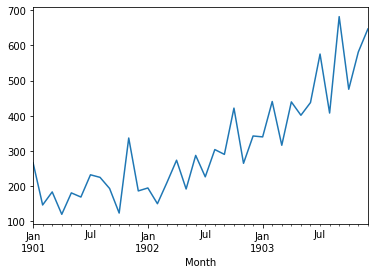

In [28]:
series.plot()

## Data preprocessing

In [29]:
def series_to_dataset(data, lag=1):
    dataframe = pd.DataFrame(data)
    cols = [dataframe.shift(i) for i in range(1, lag+1)]
    cols.append(dataframe)
    dataframe = pd.concat(cols, axis=1)
    dataframe.fillna(0, inplace=True)
    return dataframe

In [30]:
X = series.values
df = series_to_dataset(X, 1)
df.head()

,0,0
0,0.0,266.0
1,266.0,145.9
2,145.9,183.1
3,183.1,119.3
4,119.3,180.3


## Statioanary data

In [31]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [32]:
def inverse_difference(history, y_hat, interval=1):
    return y_hat + history[-interval]

In [33]:
differenced = difference(series, 1)
print(differenced.head())
inverted = []
for i in range(len(differenced)):
    value = inverse_difference(series, differenced[i], len(series)-i)
    inverted.append(value)
inverted = pd.Series(inverted)
print(inverted.head())

0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


## Scale

In [34]:
from sklearn.preprocessing import MinMaxScaler

def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [45]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

## All preprocessing

In [46]:
series = pd.read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))

scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = pd.Series(scaled_X[:, 0])

inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = pd.Series(inverted_X[:, 0])

C:\Users\alexe\AppData\Local\Temp\ipykernel_1108\2152988286.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


In [47]:
scaled_series.head(), inverted_series.head()

(0   -0.478585
 1   -0.905456
 2   -0.773236
 3   -1.000000
 4   -0.783188
 dtype: float64,
 0    266.0
 1    145.9
 2    183.1
 3    119.3
 4    180.3
 dtype: float64)

## LSTM

In [48]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [49]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [50]:
series = pd.read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
raw_values = series.values
diff_values = difference(series, 1)
raw_values.shape, diff_values.shape

C:\Users\alexe\AppData\Local\Temp\ipykernel_1108\472445676.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


((36,), (35,))

In [51]:
df = series_to_dataset(diff_values, 1)
df_values = df.values
train, test = df_values[0:-12], df_values[-12:]
train.shape

(23, 2)

In [52]:
train, test = df_values[0:-12], df_values[-12:]
scaler, train_scaled, test_scaled = scale(train, test)

In [53]:
lstm_model = fit_lstm(train_scaled, 1, 100, 3)
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.07738751],
       [ 0.35206592],
       [-0.13405386],
       [ 0.21946682],
       [-0.31891233],
       [-0.04660026],
       [-0.3897016 ],
       [-0.10118706],
       [ 0.06667759],
       [ 0.27831215],
       [-0.9391745 ],
       [ 0.18793385],
       [-0.07953113],
       [ 0.16375853],
       [-0.32558262],
       [-0.42282635],
       [ 0.16409378],
       [-0.49795568],
       [ 0.10642277],
       [-0.4248314 ],
       [-0.06728981],
       [-0.6984917 ],
       [ 0.2268015 ]], dtype=float32)

Month=1, Predicted=311.942039, Expected=339.700000
Month=2, Predicted=349.709235, Expected=440.400000
Month=3, Predicted=360.843633, Expected=315.900000
Month=4, Predicted=391.914280, Expected=439.300000
Month=5, Predicted=363.719453, Expected=401.300000
Month=6, Predicted=427.634963, Expected=437.400000
Month=7, Predicted=424.061603, Expected=575.500000
Month=8, Predicted=460.935758, Expected=407.600000
Month=9, Predicted=481.743406, Expected=682.000000
Month=10, Predicted=529.382348, Expected=475.300000
Month=11, Predicted=515.527481, Expected=581.300000
Month=12, Predicted=523.340491, Expected=646.900000
Test RMSE: 92.721


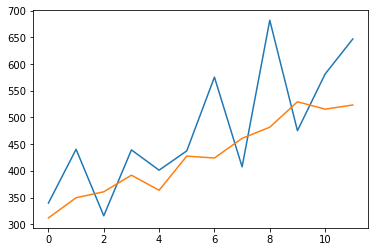

In [58]:
from sklearn.metrics import mean_squared_error

lstm_model = fit_lstm(train_scaled, 1, 100, 4)
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

predictions = list()
for i in range(len(test_scaled)):
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	yhat = invert_scale(scaler, X, yhat)
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
rmse = np.sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
plt.plot(raw_values[-12:])
plt.plot(predictions)
plt.show()

In [63]:
neurons = range(3, 10)
scores = []
for neuron in neurons:
    lstm_model = fit_lstm(train_scaled, 1, 1500, neuron)
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    predictions = list()
    for i in range(len(test_scaled)):
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        yhat = invert_scale(scaler, X, yhat)
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        predictions.append(yhat)
                
    rmse = np.sqrt(mean_squared_error(raw_values[-12:], predictions))
    scores.append(rmse)

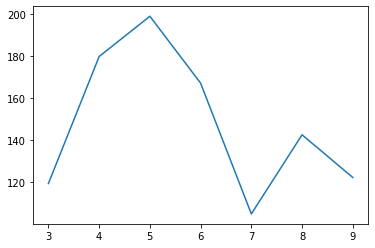

In [64]:
plt.plot(neurons, scores)